Mount Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import gradio as gr
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



Dataset path

In [10]:
base_path = "/content/drive/MyDrive/Flower Image Classification"
train_path = base_path + "/Images"
sample_path = base_path + "/Samples"



Count of each classes

In [11]:
print("📁 Checking dataset folders...\n")

classes = sorted(os.listdir(train_path))
print("Classes found:", classes)

total_images = 0
for cls in classes:
    cls_path = os.path.join(train_path, cls)
    count = len(os.listdir(cls_path))
    total_images += count
    print(f"➡ {cls}: {count} images")

print(f"\n📸 Total images in dataset: {total_images}")


📁 Checking dataset folders...

Classes found: ['daisy', 'dandelion', 'rose']
➡ daisy: 764 images
➡ dandelion: 1052 images
➡ rose: 784 images

📸 Total images in dataset: 2600


View Sample Images

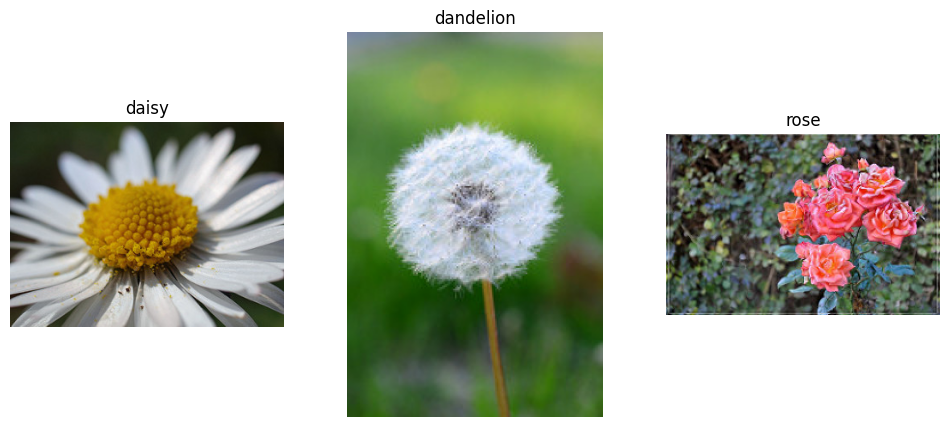

In [12]:
import matplotlib.image as mpimg

plt.figure(figsize=(12,5))
i = 1
for cls in classes:
    img_path = os.path.join(train_path, cls, os.listdir(os.path.join(train_path, cls))[0])
    img = mpimg.imread(img_path)
    plt.subplot(1, 3, i)
    plt.title(cls)
    plt.imshow(img)
    plt.axis("off")
    i += 1
plt.show()



Data Generators

In [13]:

img_height, img_width = 150, 150
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

class_names = list(train_data.class_indices.keys())
print("Class names:", class_names)


Found 2082 images belonging to 3 classes.
Found 518 images belonging to 3 classes.
Class names: ['daisy', 'dandelion', 'rose']


Model to avoid overfitting

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.3938 - loss: 1.2746 - val_accuracy: 0.6371 - val_loss: 0.8427
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.6193 - loss: 0.8249 - val_accuracy: 0.7066 - val_loss: 0.7011
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.7044 - loss: 0.7108 - val_accuracy: 0.7355 - val_loss: 0.6187
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.7686 - loss: 0.6137 - val_accuracy: 0.7046 - val_loss: 0.6740
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.7817 - loss: 0.5528 - val_accuracy: 0.7510 - val_loss: 0.6234
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.8310 - loss: 0.4276 - val_accuracy: 0.7645 - val_loss: 0.5615
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.8591 - loss: 0.3704 - val_accuracy: 0.7973 - val_loss: 0.5563
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.8924 - loss: 0.2958 - val_accura

Plot training curves

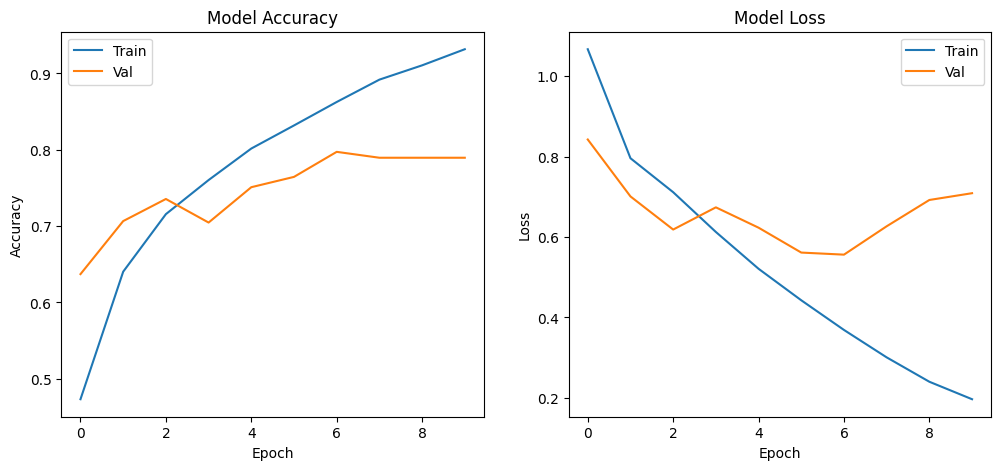

In [16]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])

plt.show()


Confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step


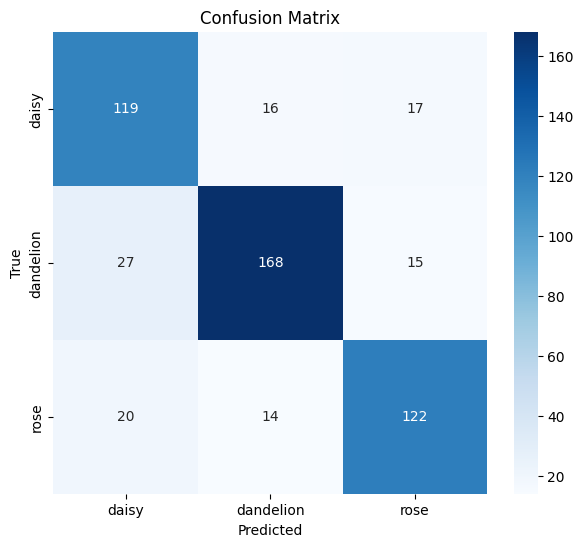


Classification Report:

              precision    recall  f1-score   support

       daisy       0.72      0.78      0.75       152
   dandelion       0.85      0.80      0.82       210
        rose       0.79      0.78      0.79       156

    accuracy                           0.79       518
   macro avg       0.79      0.79      0.79       518
weighted avg       0.79      0.79      0.79       518



In [17]:
y_true = val_data.classes
pred_probs = model.predict(val_data)
y_pred = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Save model

In [18]:
model.save("flower_model.h5")
print("Model saved!")


Model saved!


Gradio app

In [19]:
def predict_image(img):
    img = img.resize((150,150))
    img = np.array(img)/255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    return {class_names[i]: float(pred[i]) for i in range(3)}

gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="🌸 Flower Image Classification - Rose / Daisy / Dandelion"
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5c1fa1c934d055eae5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
